##### This notebook is in the context of the paper on illustrating the concepts of a selection function and of its use in astronomy through the devising, cleaning, and SF-correcting of a sample of white dwarfs with the goal to get the luminosity color function. This first part of the notebook is about

-- starting with a raw initial sample

-- attaching astrometric fidelity flags from Rybizki et al 2019, which eliminates techicbally spurious objects

-- making a color-color cut in the BP-G and G-RP plane, to isolate objects with single-WD SEDs, which eliminates "physical contaminants" (correctly measured objects that are not single WDs)

In [1]:
# initial set-up stuff
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from pylatex import Document, Section, Subsection, Table, Math, TikZ, Axis, \
    Plot, Figure, Package

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.colors as colors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

from astropy.io import fits
import os

rc('text', usetex = True)
rc('font', family = 'serif', weight = 'normal', size = 20)
font = {'family': 'monospace',
        'color':  'black',
        'weight': 'bold',
        'size': 20,
        }
color_map = plt.cm.get_cmap('inferno')
rainbow = plt.cm.get_cmap('rainbow')
greyscale = plt.cm.get_cmap('Greys')
reverse_inferno = color_map.reversed()

#directory in which all inopout and output files live
work_directory = '/Users/rix/Science/Projects/Gaia/Gaia-Unlimited/SF-WD_paper/'

The starting point is a Gaia eDR3 query that is designed to get possible WDs (2 magnitudes below the MS at the same color), within 1/3 kpc, and G<20 and "at least decent parallax S/N:  $\delta\varpi/\varpi >5$.

<font color=blue>
SELECT * <br>
    FROM gaiaedr3.gaia_source AS g <br>
    WHERE <br>
    g.phot_g_mean_mag $<$ 20.0 <br>
    and g.parallax > 3. <br>
    and g.parallax_over_error > 5.<br>
    and g.phot_g_mean_mag +5*log10(g.parallax/100.) > 4.+ (13./3.3)*(g.bp_rp+0.8) <br>
 </font>
 
 where the last condition is a broad cut in CMD-space, "well below the main sequence"


In [2]:
# read in the initial catalog
#file_name = 'WD-for-paper-Jan23-2021-result.fits'
file_name = 'WD-Jan31-2021-initial-sample.fits'
file_path = os.path.join(work_directory, file_name)
hdul = fits.open(file_path)[1]
catalog = hdul.data
#get the few columns we need; without subscript refers to the innitial sample
BmR = catalog['bp_rp']
MG = catalog['phot_g_mean_mag']+5*np.log10(catalog['parallax'])-10.
l = catalog['l']
b = catalog['b']
print('read in ',catalog.shape[0],' catalog rows')

read in  737899  catalog rows


We will end up making a number of 2D point-density histograms, and will set up a function to calculate them here

In [3]:
def construct_twoDhistogram(Xdata,Ydata,weight,xmin,xmax,ymin,ymax,gridsize,zero_avoidance):
    # Xdata and Ydata need to be two equally long arrays that tell us where the point lie
    # weight of each data point; if we are just counting, 
    #      then weight has to be an array of ones, as long as X/Ydata; weight better be >=0.
    # gridsize: same in X and Y here
    # xmin,xmax,ymin,ymag: hopefully self-explanatory; make sure max > min!
    # zero_avoidance: we'll take log of the number density at the end
    grid = np.zeros((gridsize,gridsize))+zero_avoidance
    xindex = np.zeros(len(Xdata))
    yindex = np.zeros(len(Xdata))
    dx = (xmax-xmin)/(gridsize)
    dy = (ymax-ymin)/(gridsize)
    for i in range(len(Xdata)):
        ix = np.minimum(np.maximum(0,np.int((Xdata[i]-xmin)/dx)),gridsize-1)
        iy = np.minimum(np.maximum(0,np.int((Ydata[i]-ymin)/dy)),gridsize-1) 
        if (ix != np.int((Xdata[i]-xmin)/dx)): weight[i] = 0
        if (iy != np.int((Ydata[i]-ymin)/dy)): weight[i] = 0
        xindex[i] = ix
        yindex[i] = iy
        grid[ix,iy] = grid[ix,iy] + weight[i]
    grid_log = np.log10(grid/(dx*dy))  # resulting units "log density per pixel"
    return grid_log,xindex,yindex

Let's have a look at some of the basic properties of the sample.
We do this by showing the absG vs BP-RP distribution of the sample, along with the marginalized histogram distributions.

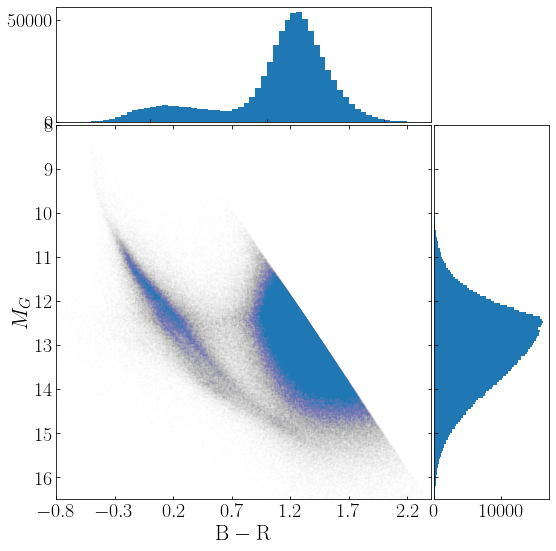

<Figure size 432x288 with 0 Axes>

In [4]:
# CMD plot
x = BmR
y = MG

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
plt.xticks(np.arange(-0.8, 2.4, 0.5))

# the scatter plot:
ax_scatter.scatter(x, y,s=2,alpha=0.002)
plt.xlabel(r'${\mathrm B}-{\mathrm R}$',size=22)
plt.ylabel(r'$M_G$',size=22)

# now onto the marginalized distributions

ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)




# now determine nice limits by hand:
binwidth = 0.05
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-0.8, 2.4))
ax_scatter.set_ylim((16.5,8.))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')


ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

#plt.tight_layout()

plt.show()
file_name = 'initial_eDR3_query_CMD_distribution.png'
file_path = os.path.join(work_directory, file_name)
plt.savefig(file_path,format='png')   # the output did not come our right; to be checked

The plot above shows the enormous numbers of "spurious" sources that are in this largely empty part of the CAMD. Rybizki et al have devised an astrometric fidelity parameter (prob_v1), which is good at eliminating spurious sources. We have via the GAVO interface matched the above sample with prob_v1 and have picked prob_v1>0.9. This results in the following file which we plot analogously.

In [5]:
file_name = 'WD-Jan31-2021-fidelity-ge-0.9.fits'
file_path = os.path.join(work_directory, file_name)
hdul = fits.open(file_path)[1]
catalog_af = hdul.data
#get the few columns we need; "_af" refers to the variables after the astromnetric fidelity cleaning
BmR_af = catalog_af['bp_rp']
MG_af = catalog_af['phot_g_mean_mag']+5*np.log10(catalog_af['parallax'])-10.
l = catalog_af['l']
b = catalog_af['b']
print(catalog_af.shape)

(126638,)


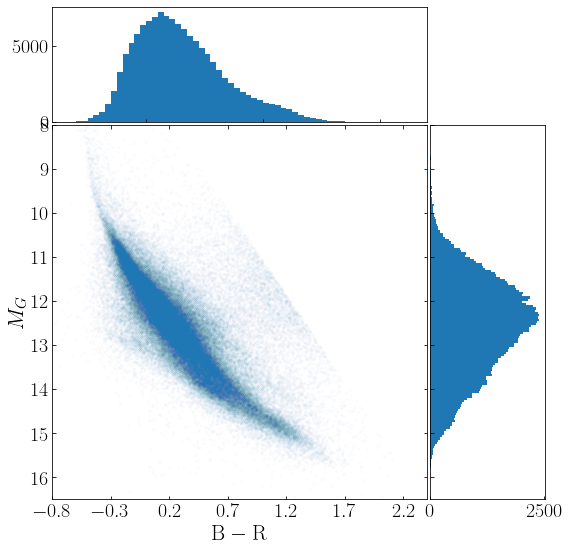

<Figure size 432x288 with 0 Axes>

In [6]:
# CMD plot
x = BmR_af
y = MG_af

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
plt.xticks(np.arange(-0.8, 2.4, 0.5))

# the scatter plot:
ax_scatter.scatter(x, y,s=5,alpha=0.01)
plt.xlabel(r'${\mathrm B}-{\mathrm R}$',size=22)
plt.ylabel('$M_G$',size=22)

# now onto the marginalized distributions

ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)




# now determine nice limits by hand:
binwidth = 0.05
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-0.8, 2.4))
ax_scatter.set_ylim((16.5,8.))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')


ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

#plt.tight_layout()

plt.show()
file_name = 'astrometrical_fidelity_cleaned_CAMD_distribution.png'
file_path = os.path.join(work_directory, file_name)
plt.savefig(file_path,format='png')   # the output did not come our right; to be checked

Let's look at what that cleaningh did to the sky distrbution

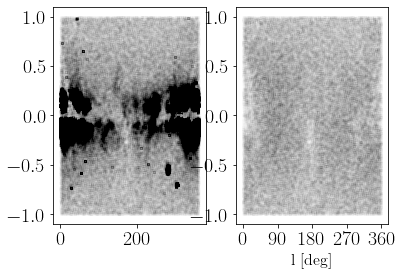

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(catalog['l'],np.sin(catalog['b']* np.pi / 180.),'.', color='black',alpha=0.002)
plt.xlabel('l [deg]',size=16)
ax2.plot(catalog_af['l'],np.sin(catalog_af['b']* np.pi / 180.),'.', color='black',alpha=0.002)
plt.xticks(np.arange(0., 361., 90.))
#plt.yticks(np.arange(-1.7, 1.7, 0.5))
plt.xlabel(r'l [deg]',size=16)
plt.ylabel(r'$\sin{b}$',size=16)
plt.show()

And now, yet again another cleaning step:  we will eliminate objects whose position in the color-color plane shows that their SEDs are more complex than a single black-body (stellar spectrum); we seek to model single WDs, which **all** should satisfy this criterion; again, a contamination reduction without significant completenes reduction (except that we will retain binary WDs where both components have similar T$_{eff}$).

We chosse BP-G *vs* G-RP as the coordinates of the color-color-plane. The two panels show the full extent of the color-color plane (left) and a zoom in to the single-stellar(WD) locus. The red dots show an eyeballed selection criterion.


In [8]:
BmG_af = catalog_af['phot_bp_mean_mag'] - catalog_af['phot_g_mean_mag']
GmR_af = catalog_af['phot_g_mean_mag'] - catalog_af['phot_rp_mean_mag']
weight = np.ones(len(BmG_af))
xmin,xmax,ymin,ymax=-4.,1.4,-1.0,4.1
gridsize,floor=200,1.e-7
color_color_density,xind,yind = construct_twoDhistogram(BmG_af,GmR_af,weight,xmin,xmax,ymin,ymax,gridsize,floor)

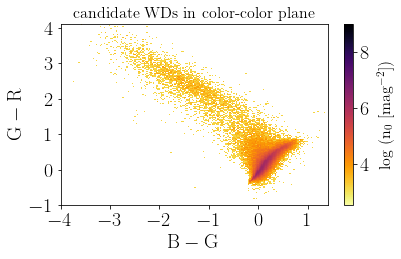

<Figure size 432x288 with 0 Axes>

In [9]:
font = {'family': 'monospace',
        'color':  'black',
        'weight': 'bold',
        'size': 20,
        }
color_map = plt.cm.get_cmap('inferno')
reverse_inferno = color_map.reversed()
distribution = np.ma.masked_where(color_color_density < -0., color_color_density).T
                            
plt.imshow(distribution, extent=[xmin,xmax,ymin,ymax],aspect='auto',interpolation='none',cmap=reverse_inferno,vmin=2.5,vmax=9.,origin='lower'
          ) 
plt.xlabel(r'${\mathrm B}-{\mathrm G}$')
plt.ylabel(r'${\mathrm G}-{\mathrm R}$')
plt.title(r'candidate WDs in color-color plane',fontsize=16)
plt.xticks(np.arange(xmin, xmax, 1.))
plt.yticks(np.arange(ymin, ymax, 1.))
clb = plt.colorbar()
clb.set_label("log $( \mathrm{n}_0~[\mathrm{mag}^{-2}])$", labelpad=8, rotation=90, fontsize=16)
file_name = 'color_color_distribution1.png'
file_path = os.path.join(work_directory, file_name)
plt.tight_layout()
plt.show() 
plt.savefig(file_path,format='png')

Now we'll make a zoomed in version of the plot

In [10]:
BmG_af = catalog_af['phot_bp_mean_mag'] - catalog_af['phot_g_mean_mag']
GmR_af = catalog_af['phot_g_mean_mag'] - catalog_af['phot_rp_mean_mag']
weight = np.ones(len(BmG_af))
xmin,xmax,ymin,ymax=-0.5,1.05,-0.5,1.2
gridsize,floor=200,1.e-7
color_color_density,xind,yind = construct_twoDhistogram(BmG_af,GmR_af,weight,xmin,xmax,ymin,ymax,gridsize,floor)

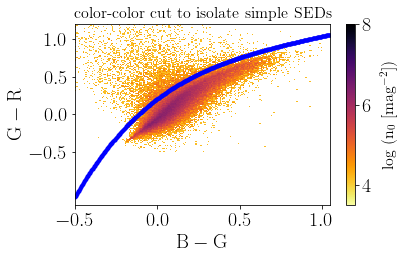

<Figure size 432x288 with 0 Axes>

In [11]:
font = {'family': 'monospace',
        'color':  'black',
        'weight': 'bold',
        'size': 20,
        }
color_map = plt.cm.get_cmap('inferno')
reverse_inferno = color_map.reversed()
distribution = np.ma.masked_where(color_color_density < -0., color_color_density).T
# that .T transpose matters; cost me an hour of my life
                            
plt.imshow(distribution, extent=[xmin,xmax,ymin,ymax],aspect='auto',interpolation='none',cmap=reverse_inferno,vmin=3.5,vmax=8.,origin='lower'
          ) 
plt.xlabel(r'${\mathrm B}-{\mathrm G}$')
plt.ylabel(r'${\mathrm G}-{\mathrm R}$')
plt.title(r'color-color cut to isolate simple SEDs',fontsize=16)
plt.xticks(np.arange(xmin, xmax, 0.5))
plt.yticks(np.arange(ymin, ymax, 0.5))
clb = plt.colorbar()
clb.set_label("log $( \mathrm{n}_0~[\mathrm{mag}^{-2}])$", labelpad=8, rotation=90, fontsize=16)
file_name = 'color_color_distribution2.png'

x = np.linspace(xmin, xmax, num=500)
y = 0.48+ 1.15*(x-0.2) - 1.0*(x-0.2)**2 + 0.70*(x-0.2)**3.-0.2*(x-0.2)**4
plt.plot(x,y,'.',color='blue',alpha=0.9)
file_path = os.path.join(work_directory, file_name)
plt.tight_layout()
plt.show() 
plt.savefig(file_path,format='png')




In [12]:
#now demand that "good" objects lie below the red dots, i.e. satisfy the single-$T_{eff$}$ SED cut
x=BmG_af
GmRmax = 0.48+ 1.15*(x-0.2) - 1.0*(x-0.2)**2 + 0.70*(x-0.2)**3.-0.2*(x-0.2)**4

iselect = (GmR_af < GmRmax) 
# subscript "_c" refers to quantities after the color-color cut
catalog_c = catalog_af[iselect]
BmR_c = BmR_af[iselect]
MG_c = MG_af[iselect]
print('We have now selected',len(MG_c),' candidates')

We have now selected 113383  candidates


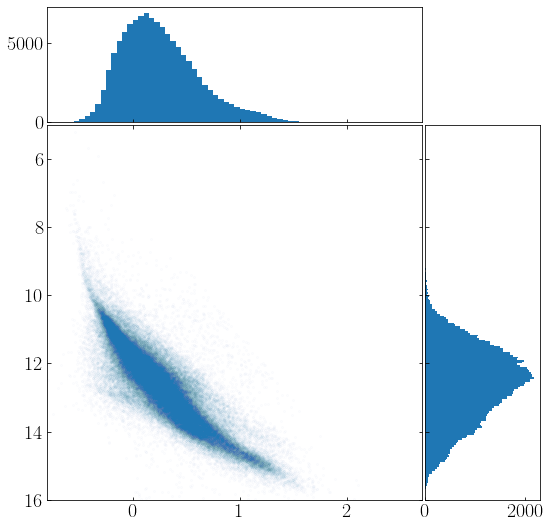

In [13]:
# the random data
x = BmR_c
y = MG_c

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y,s=5,alpha=0.01)

# now determine nice limits by hand:
binwidth = 0.05
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-0.8, 2.7))
ax_scatter.set_ylim((16.,5.))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

Let's now look at what all that cleaning did to the sky distribution: it does look pleasing 

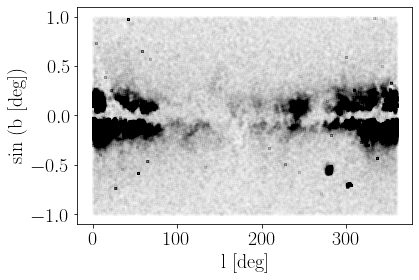

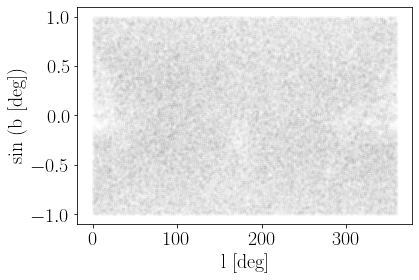

In [14]:
plt.plot(catalog['l'],np.sin(catalog['b']/57.2958),'.', color='black',alpha=0.005)
plt.ylabel(' sin (b [deg])')
plt.xlabel(' l [deg]')
plt.show()
plt.plot(catalog_c['l'],np.sin(catalog_c['b']/57.2958),'.', color='black',alpha=0.005)
plt.ylabel(' sin (b [deg])')
plt.xlabel(' l [deg]')
plt.show()

Now calculate the maximal volume for each points, assuming a homogeneous distribution and no dust. There are three aspects that can limit the maximal volume:
1. the formal parallax cut
2. the magnitude limit
3. the plxSNlim

In [15]:
Glimit = 19.5
plxSNmin = 20.
plxcut = 3.
# subscript "_cut" refers to the sample aftetr (various) plxS/N cuts
iselect = np.all([ catalog_c['phot_g_mean_mag']<=Glimit, catalog_c['parallax'] >= plxcut, \
                  catalog_c['parallax_over_error'] >= plxSNmin ],axis=0)
catalog_cut = catalog_c[iselect]
BmR_cut = catalog_cut['bp_rp']
MG_cut = catalog_cut['phot_g_mean_mag']+5*np.log10(catalog_cut['parallax'])-10.
print('The initial catalog of ',len(catalog_c),' sample members gets pared down to',len(catalog_cut))

The initial catalog of  113383  sample members gets pared down to 57858


In [16]:
# assign to each object in 'catalog' a Vmax; not catalog must have columns 'parallax' and 'phot_g_mean_mag'
# the assumption is that we have cuts in parallax (plxmin), magnitude (Glimit), and PlsS/N
# there are three possible issues that limit Vmax: plxcit, Gmin o plxSN; hence thee cases
def get_Vmax(catalog,M,Glimit,plxSNmin,plxcut):
    Gref = 21 # reference magnitude so that m and varpi yield a cetain plxSN; empiically calibrated fom eDR3
    Vmax_1 = 4*np.pi/3*(1./plxcut**3)
    Vmax_2 = 4*np.pi/3* 10**(-3*(M+10-Glimit)/5)
    # wrong!! plxmin = plxSNmin*10.**(-(22.-catalog_3['phot_g_mean_mag'])/5.)
    plxmin = (plxSNmin*10.**((M-11)/2.5))**(1./3)
    # wrong!! SNexpected = (catalog['parallax']*10**(-(catalog['phot_g_mean_mag']-Gref)/2.5))
    Vmax_3 = 4*np.pi/3*(1./plxmin**3)
    return np.minimum(np.minimum(Vmax_1,Vmax_2),Vmax_3)

# variant of the above, to get effective survey volume
def get_Vmax_dummy(M,Glimit,plxSNmin,plxcut):   # this version just takes an array of abs. mags (e.g. those n the grid)
                                                # this is to calculate V_eff survey volume
    Gref = 21 # reference magnitude so that m and varpi yield a cetain plxSN; empiically calibrated fom eDR3
    Vmax_1 = 4*np.pi/3*(1./plxcut**3)
    Vmax_2 = 4*np.pi/3* 10**(-3*(M+10-Glimit)/5)
    plxmin = (plxSNmin*10.**((M-11)/2.5))**(1./3)
    Vmax_3 = 4*np.pi/3*(1./plxmin**3)
    return np.minimum(np.minimum(Vmax_1,Vmax_2),Vmax_3)
    

Now get the Vmax for all objects in catalog_cut

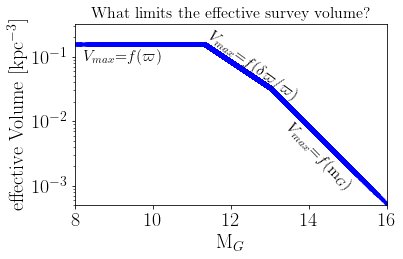

In [17]:
Vmax_cut = get_Vmax(catalog_cut,MG_cut,Glimit,plxSNmin,plxcut)
plt.plot(MG_cut,Vmax_cut,'.', color='blue',alpha=1.)
plt.xlabel('$\mathrm{M}_G$')
plt.ylabel('effective Volume [kpc$^{-3}$]')
plt.title(r'What limits the effective survey volume?',fontsize=16)
plt.ylim(0.0005,0.32)
plt.xlim(8.,16.)
plt.text(8.2,0.085, r'$V_{max}$=$f(\varpi)$', fontsize=16,
               rotation=0, rotation_mode='anchor')
plt.text(11.4,0.2, r'$V_{max}$=$f(\delta\varpi/\varpi)$', fontsize=16,
               rotation=-36, rotation_mode='anchor')
plt.text(13.4,0.008, r'$V_{max}$=$f(\mathrm{m}_G)$', fontsize=16,
               rotation=-46, rotation_mode='anchor')
plt.semilogy()
plt.tight_layout()
filename = "/Users/rix/Science/Projects/Gaia/Gaia-Unlimited/Veff.png".format(str(np.int(plxSNmin)))
plt.savefig(filename)
plt.show()


Now, let's set up a 100x100 grid in MG-(B-R) space, weigh each point by 1./Vmax(M_G)
and make a plot; this is effectively the luminosity-color function of single WDs.

In [18]:
# this is function that turns a set of points into a density on a pre-defined grid; the grid is masked in empty patches
def get_density(M,c,Mmin,Mmax,cmin,cmax,Vmax,gridsize):
    M_c_grid = np.zeros((gridsize,gridsize))+1.e-20
    dM = (Mmax-Mmin)/gridsize
    dc = (cmax-cmin)/gridsize
    for i in range(len(M)):
        iM = np.int((M[i]-Mmin)/dM)
        iM = max(0,iM)
        iM = min(iM,gridsize-1)
        ic = np.int((c[i]-cmin)/dc)
        ic = max(0,ic)
        ic = min(ic,gridsize-1)
        M_c_grid[iM,ic] = M_c_grid[iM,ic] + 1./Vmax[i]
        # we have such high dynamic range, that we take the log
    M_c_grid_log = np.log10((1.e-9/ (dM*dc)) * M_c_grid) # now units are mag-2 pc-3
    return M_c_grid_log

# this is a dummy version of the above, intended to give is the same density map, but now it looks like V_eff
def get_density_dummy(Mmin,Mmax,cmin,cmax,gridsize,Glimit,plxSNmin,plxcut):
    M_c_grid = np.zeros((gridsize,gridsize))+1.e-20
    dM = (Mmax-Mmin)/gridsize
    dc = (cmax-cmin)/gridsize
    M_dummy = np.linspace(Mmin,Mmax,gridsize)
    Vmax_dummy = get_Vmax_dummy(M_dummy,Glimit,plxSNmin,plxcut)
    
    for i in range(gridsize):
        for j in range(gridsize):
            M_c_grid[i,j] = 1./Vmax_dummy[i]
        # we have such high dynamic range, that we take the log
    M_c_grid_log = np.log10((1.e-9/ (dM*dc)) * M_c_grid) # now units are mag-2 pc-3
    return M_c_grid_log

In [19]:
# now get the color-magnitude-density distribution; start by setting basic parameters
MGmin,MGmax,BmRmin,BmRmax = 5,17.,-0.8,1.8
gridsize = 120

Now we will make the first WD CLF on the grid just specified, taking default parameters

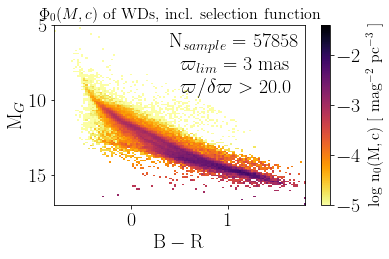

In [20]:
distribution = get_density(MG_cut,BmR_cut,MGmin,MGmax,BmRmin,BmRmax,Vmax_cut,gridsize)
#and mask it for plotting purposes
distribution = np.ma.masked_where(distribution < -10., distribution)
                            
plt.imshow(distribution, extent=[BmRmin,BmRmax,MGmax,MGmin],aspect='auto',interpolation='none',cmap=reverse_inferno,vmin=-5.,vmax=-1.4
          ) 
plt.xlabel(r'${\mathrm B}-{\mathrm R}$')
plt.ylabel(r'${\mathrm M}_G$')
plt.title(r'$\Phi_0(M,c)$ of WDs, incl. selection function',fontsize=16)
clb = plt.colorbar()
clb.set_label("log $\mathrm{n}_0(\mathrm{M,c})\ [~\mathrm{mag}^{-2}~ \mathrm{pc}^{-3}~]$", labelpad=4, rotation=90, fontsize=16)
plt.text(0.4,6.5, "N$_{sample}$ = "+str(len(Vmax_cut)),fontdict=font)
plt.text(0.5,8., r"$\varpi_{lim}=3$ mas",fontdict=font)
plt.text(0.5,9.5, r"$\varpi/\delta\varpi>$ "+str(plxSNmin),fontdict=font)
plt.tight_layout()
filename = "/Users/rix/Science/Projects/Gaia/Gaia-Unlimited/WD300pc_plxSN_{}.png".format(str(np.int(plxSNmin)))
plt.savefig(filename)
plt.show() 

Now we will make a map that looks like the above, but just has V_eff, i.e. presumes that each pixel has 1 point in it

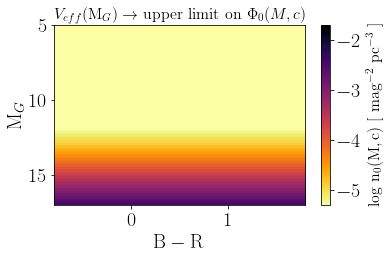

In [21]:
distribution_dummy = get_density_dummy(MGmin,MGmax,BmRmin,BmRmax,gridsize,Glimit,plxSNmin,plxcut)
#and mask it for plotting purposes
distribution_dummy = np.ma.masked_where(distribution_dummy < -10., distribution_dummy)
                            
plt.imshow(distribution_dummy, extent=[BmRmin,BmRmax,MGmax,MGmin],aspect='auto',interpolation='none',cmap=reverse_inferno,vmin=-5.3,vmax=-1.7
          ) 
plt.xlabel(r'${\mathrm B}-{\mathrm R}$')
plt.ylabel(r'${\mathrm M}_G$')
plt.title(r'$V_{eff}({\mathrm M}_G)\rightarrow $ upper limit on $\Phi_0(M,c)$',fontsize=16)
clb = plt.colorbar()
clb.set_label("log $\mathrm{n}_0(\mathrm{M,c})\ [~\mathrm{mag}^{-2}~ \mathrm{pc}^{-3}~]$", labelpad=4, rotation=90, fontsize=16)
#plt.text(0.4,6.5, "$N_{sample}$ = "+str(len(Vmax_cut)),fontdict=font)
#plt.text(0.5,8., "$\omega_{lim}=3$ mas",fontdict=font)
#plt.text(0.5,9.5, "$\omega/\delta\omega>$ "+str(plxSNmin),fontdict=font)
plt.tight_layout()
filename = "/Users/rix/Science/Projects/Gaia/Gaia-Unlimited/WD300pc_survey_volume.png".format(str(np.int(plxSNmin)))
plt.savefig(filename)
plt.show() 

Let's now compare this to the un-corrected distribution: we do this by setting Vmax=1 for all points

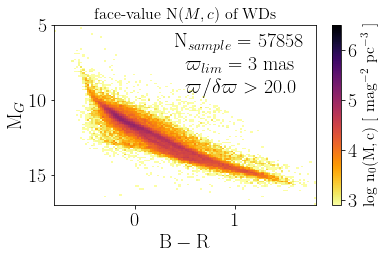

In [22]:
Vmax_dummy = np.ones(len(MG_cut))
distribution = 9+ get_density(MG_cut,BmR_cut,MGmin,MGmax,BmRmin,BmRmax,Vmax_dummy,gridsize)  # undo (stupid) pc^3-->kpc^3 unit conversion
#and mask it for plotting purposes
distribution = np.ma.masked_where(distribution < -10., distribution)

#consider also color map 'reverse_inferno'
plt.imshow(distribution, extent=[BmRmin,BmRmax,MGmax,MGmin],aspect='auto',interpolation='none',cmap=reverse_inferno,vmin=2.9,vmax=6.5
          ) 
plt.xlabel(r'${\mathrm B}-{\mathrm R}$')
plt.ylabel(r'${\mathrm M}_G$')
plt.title(r'face-value $\mathrm{N}(M,c)$ of WDs',fontsize=16)
clb = plt.colorbar()
clb.set_label("log $\mathrm{n}_0(\mathrm{M,c})\ [~\mathrm{mag}^{-2}~ \mathrm{pc}^{-3}~]$", labelpad=4, rotation=90, fontsize=16)
plt.text(0.4,6.5, r"N$_{sample}$ = "+str(len(Vmax_dummy)),fontdict=font)
plt.text(0.5,8., r"$\varpi_{lim}=3$ mas",fontdict=font)
plt.text(0.5,9.5, r"$\varpi/\delta\varpi >$ "+str(plxSNmin),fontdict=font)
plt.tight_layout()
filename = "/Users/rix/Science/Projects/Gaia/Gaia-Unlimited/WD300pc_plxSN_{}_uncorr.png".format(str(np.int(plxSNmin)))
plt.savefig(filename)
plt.show() 

Admittedly as an afterthought, let's now make analogous plots if the initial, _af and (full) _c sample

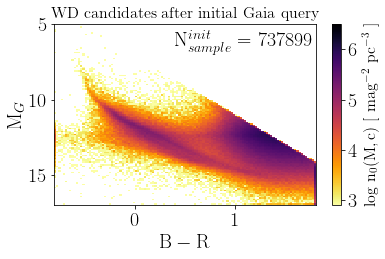

In [23]:
# we start with the initial sample
Vmax_dummy = np.ones(len(MG))
distribution = 9+ get_density(MG,BmR,MGmin,MGmax,BmRmin,BmRmax,Vmax_dummy,gridsize)  # undo (stupid) pc^3-->kpc^3 unit conversion
#and mask it for plotting purposes
distribution = np.ma.masked_where(distribution < -10., distribution)

#consider also color map 'reverse_inferno'
plt.imshow(distribution, extent=[BmRmin,BmRmax,MGmax,MGmin],aspect='auto',interpolation='none',cmap=reverse_inferno,vmin=2.9,vmax=6.5
          ) 
plt.xlabel(r'${\mathrm B}-{\mathrm R}$')
plt.ylabel(r'${\mathrm M}_G$')
plt.title(r'WD candidates after initial Gaia query',fontsize=16)
clb = plt.colorbar()
clb.set_label(r"log $\mathrm{n}_0(\mathrm{M,c})\ [~\mathrm{mag}^{-2}~ \mathrm{pc}^{-3}~]$", labelpad=4, rotation=90, fontsize=16)
plt.text(0.4,6.5, r"N$^{init}_{sample}$ = "+str(len(Vmax_dummy)),fontdict=font)
plt.tight_layout()
filename = "/Users/rix/Science/Projects/Gaia/Gaia-Unlimited/WD300pc_init.png"
plt.savefig(filename)
plt.show() 

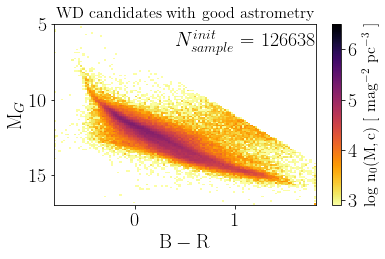

In [24]:
# now we do the fill "_af" sample (after astrometric fidelity cleaning)
Vmax_dummy = np.ones(len(MG_af))
distribution = 9+ get_density(MG_af,BmR_af,MGmin,MGmax,BmRmin,BmRmax,Vmax_dummy,gridsize)  # undo (stupid) pc^3-->kpc^3 unit conversion
#and mask it for plotting purposes
distribution = np.ma.masked_where(distribution < -10., distribution)

#consider also color map 'reverse_inferno'
plt.imshow(distribution, extent=[BmRmin,BmRmax,MGmax,MGmin],aspect='auto',interpolation='none',cmap=reverse_inferno,vmin=2.9,vmax=6.5
          ) 
plt.xlabel(r'${\mathrm B}-{\mathrm R}$')
plt.ylabel(r'${\mathrm M}_G$')
plt.title(r'WD candidates with good astrometry',wrap=True,fontsize=16)
clb = plt.colorbar()
clb.set_label("log $\mathrm{n}_0(\mathrm{M,c})\ [~\mathrm{mag}^{-2}~ \mathrm{pc}^{-3}~]$", labelpad=4, rotation=90, fontsize=16)
plt.text(0.4,6.5, "$N^{init}_{sample}$ = "+str(len(Vmax_dummy)),fontdict=font)
plt.tight_layout()
filename = "/Users/rix/Science/Projects/Gaia/Gaia-Unlimited/WD300pc_af.png"
plt.savefig(filename)
plt.show() 

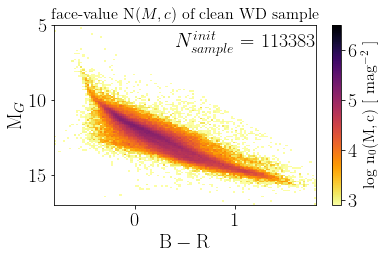

In [25]:
# and now after the SED-cleaning color-color cut "_c" sample 
Vmax_dummy = np.ones(len(MG_c))
distribution = 9+ get_density(MG_c,BmR_c,MGmin,MGmax,BmRmin,BmRmax,Vmax_dummy,gridsize)  # undo (stupid) pc^3-->kpc^3 unit conversion
#and mask it for plotting purposes
distribution = np.ma.masked_where(distribution < -10., distribution)

#consider also color map 'reverse_inferno'
plt.imshow(distribution, extent=[BmRmin,BmRmax,MGmax,MGmin],aspect='auto',interpolation='none',cmap=reverse_inferno,vmin=2.9,vmax=6.5
          ) 
plt.xlabel(r'${\mathrm B}-{\mathrm R}$')
plt.ylabel(r'${\mathrm M}_G$')
plt.title(r'face-value $\mathrm{N}(M,c)$ of clean WD sample',fontsize=16)
clb = plt.colorbar()
clb.set_label("log $\mathrm{n}_0(\mathrm{M,c})\ [~\mathrm{mag}^{-2}~]$", labelpad=4, rotation=90, fontsize=16)
plt.text(0.4,6.5, "$N^{init}_{sample}$ = "+str(len(Vmax_dummy)),fontdict=font)
plt.tight_layout()
filename = "/Users/rix/Science/Projects/Gaia/Gaia-Unlimited/WD300pc_cccut.png"
plt.savefig(filename)
plt.show() 

We will now explore the impact of changing some of the selection cuts for the seample; the estimate of the CLF should remain unbiased. More lenient $\delta\varpi/\varpi$ cuts will give larger samples, but also larger error bars in $M_G$, hence less "resolution". 

In [26]:
# we start with a very lenient plxSNmin cut; the othet cuts stay unchanged
plxSNmin = 5. # <<--------

iselect = np.all([ catalog_c['phot_g_mean_mag']<=Glimit, catalog_c['parallax'] >= plxcut, \
                  catalog_c['parallax_over_error'] >= plxSNmin ],axis=0)
catalog_cut = catalog_c[iselect]
print('The initial catalog of ',len(catalog_c),' sample members gets pared down to',len(catalog_cut))
BmR_cut = catalog_cut['bp_rp']
MG_cut = catalog_cut['phot_g_mean_mag']+5*np.log10(catalog_cut['parallax'])-10.
# and get Vmax for this subsample
Vmax_cut = get_Vmax(catalog_cut,MG_cut,Glimit,plxSNmin,plxcut)

The initial catalog of  113383  sample members gets pared down to 80438


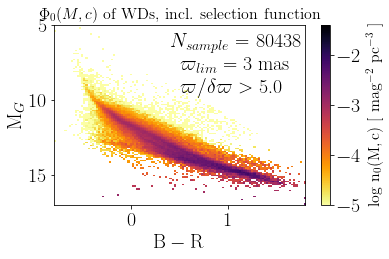

In [27]:
distribution = get_density(MG_cut,BmR_cut,MGmin,MGmax,BmRmin,BmRmax,Vmax_cut,gridsize)
#and mask it for plotting purposes
distribution = np.ma.masked_where(distribution < -10., distribution)
                            
plt.imshow(distribution, extent=[BmRmin,BmRmax,MGmax,MGmin],aspect='auto',interpolation='none',cmap=reverse_inferno,vmin=-5.,vmax=-1.4
          ) 
plt.xlabel(r'${\mathrm B}-{\mathrm R}$')
plt.ylabel(r'${\mathrm M}_G$')
plt.title(r'$\Phi_0(M,c)$ of WDs, incl. selection function',fontsize=16)
clb = plt.colorbar()
clb.set_label("log $\mathrm{n}_0(\mathrm{M,c})\ [~\mathrm{mag}^{-2}~ \mathrm{pc}^{-3}~]$", labelpad=4, rotation=90, fontsize=16)
plt.text(0.4,6.5, "$N_{sample}$ = "+str(len(Vmax_cut)),fontdict=font)
plt.text(0.5,8., r"$\varpi_{lim}=3$ mas",fontdict=font)
plt.text(0.5,9.5, r"$\varpi/\delta\varpi>$ "+str(plxSNmin),fontdict=font)
plt.tight_layout()
filename = "/Users/rix/Science/Projects/Gaia/Gaia-Unlimited/WD300pc_plxSN_{}.png".format(str(np.int(plxSNmin)))
plt.savefig(filename)
plt.show() 

In [28]:
# Now a stringent cut
plxSNmin = 80. # <<--------

iselect = np.all([ catalog_c['phot_g_mean_mag']<=Glimit, catalog_c['parallax'] >= plxcut, \
                  catalog_c['parallax_over_error'] >= plxSNmin ],axis=0)
catalog_cut = catalog_c[iselect]
print('The initial catalog of ',len(catalog_c),' sample members gets pared down to',len(catalog_cut))
BmR_cut = catalog_cut['bp_rp']
MG_cut = catalog_cut['phot_g_mean_mag']+5*np.log10(catalog_cut['parallax'])-10.
# and get Vmax for this subsample
Vmax_cut = get_Vmax(catalog_cut,MG_cut,Glimit,plxSNmin,plxcut)

The initial catalog of  113383  sample members gets pared down to 13341


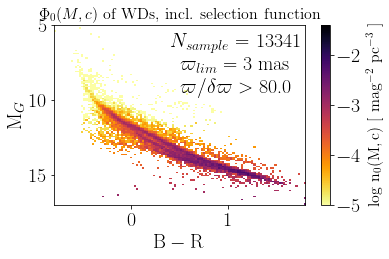

In [29]:
distribution = get_density(MG_cut,BmR_cut,MGmin,MGmax,BmRmin,BmRmax,Vmax_cut,gridsize)
#and mask it for plotting purposes
distribution = np.ma.masked_where(distribution < -10., distribution)
                            
plt.imshow(distribution, extent=[BmRmin,BmRmax,MGmax,MGmin],aspect='auto',interpolation='none',cmap=reverse_inferno,vmin=-5.,vmax=-1.4
          ) 
plt.xlabel(r'${\mathrm B}-{\mathrm R}$')
plt.ylabel(r'${\mathrm M}_G$')
plt.title(r'$\Phi_0(M,c)$ of WDs, incl. selection function',fontsize=16)
clb = plt.colorbar()
clb.set_label("log $\mathrm{n}_0(\mathrm{M,c})\ [~\mathrm{mag}^{-2}~ \mathrm{pc}^{-3}~]$", labelpad=4, rotation=90, fontsize=16)
plt.text(0.4,6.5, "$N_{sample}$ = "+str(len(Vmax_cut)),fontdict=font)
plt.text(0.5,8., r"$\varpi_{lim}=3$ mas",fontdict=font)
plt.text(0.5,9.5, r"$\varpi/\delta\varpi>$ "+str(plxSNmin),fontdict=font)
plt.tight_layout()
filename = "/Users/rix/Science/Projects/Gaia/Gaia-Unlimited/WD300pc_plxSN_{}.png".format(str(np.int(plxSNmin)))
plt.savefig(filename)
plt.show() 

Hee is an experiment to compine maps of differing S/N ; clonky!!

In [30]:
# create a 2D LCF distribution fo a set of SF parameters
# Mclim is MGmin,MGmax,BmRmin,BmRmax
def create_LCF_distibution(catalog,plxcut,plxSNmin,Glimit,gridsize,Mclim):
    iselect = np.all([ catalog['phot_g_mean_mag']<=Glimit, catalog['parallax'] >= plxcut, \
                  catalog['parallax_over_error'] >= plxSNmin ],axis=0)
    catalog_cut = catalog[iselect]
    print('The initial catalog of ',len(catalog),' sample members gets pared down to',len(catalog_cut))
    BmR_cut = catalog_cut['bp_rp']
    MG_cut = catalog_cut['phot_g_mean_mag']+5*np.log10(catalog_cut['parallax'])-10.
    # and get Vmax for this subsample
    Vmax_cut = get_Vmax(catalog_cut,MG_cut,Glimit,plxSNmin,plxcut)
    return get_density(MG_cut,BmR_cut,Mclim[0],Mclim[1],Mclim[2],Mclim[3],Vmax_cut,gridsize)

# we'll run the low plxSN sample on a coarser grid of gridsize/N (N=2,3, less emptiness) 
# and then re-create Nx larger array 
def to_larger_grid(grid,n):
    print(len(grid[0:]))
    ngrid = n*len(grid[0:])
    print(np.int(ngrid))
    largegrid=np.zeros((ngrid,ngrid))
    for i in range(ngrid):
        for j in range(ngrid):
            largegrid[i,j] = grid[np.int(i/n),np.int(j/n)]
    return largegrid

The initial catalog of  113383  sample members gets pared down to 80438
60
120
The initial catalog of  113383  sample members gets pared down to 57858
The initial catalog of  113383  sample members gets pared down to 13341
-5.526516947066639 -3.902455604822028
-5.526516947066639 -3.902455604822028


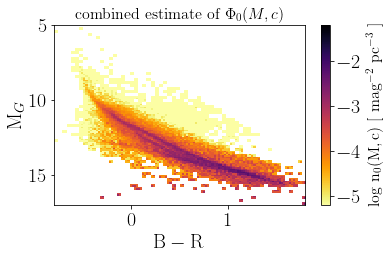

In [31]:
Mclim = (MGmin,MGmax,BmRmin,BmRmax)
#plxSNmin = 5
#distribution_5 = create_LCF_distibution(catalog_c,plxcut,plxSNmin,Glimit,gridsize,Mclim)
#distribution_5 = np.ma.masked_where(distribution_5 < -10., distribution_5)
plxSNmin = 5
distribution_5 = create_LCF_distibution(catalog_c,plxcut,plxSNmin,Glimit,np.int(gridsize/2),Mclim)
distribution_5 = to_larger_grid(distribution_5,2)
distribution_5 = np.ma.masked_where(distribution_5 < -10., distribution_5)
plxSNmin = 20
distribution_20 = create_LCF_distibution(catalog_c,plxcut,plxSNmin,Glimit,gridsize,Mclim)
distribution_20 = np.ma.masked_where(distribution_20 < -10., distribution_20)
plxSNmin = 80
distribution_80 = create_LCF_distibution(catalog_c,plxcut,plxSNmin,Glimit,gridsize,Mclim)
distribution_80 = np.ma.masked_where(distribution_80 < -10., distribution_80)

# now combine the different arrays, by successive replacement
#med_LCF_80 = np.ma.median(distribution_80.flatten())
#med_LCF_80 = np.ma.median(distribution_80.flatten())
med_LCF_80 = np.nanpercentile(np.ma.filled(distribution_80, np.nan).flatten(), 50)
mask = (distribution_80 < med_LCF_80) 
combined = np.copy(distribution_80) 
combined[mask] = distribution_20[mask]
med_LCF_comb = np.nanpercentile(np.ma.filled(combined, np.nan).flatten(), 80)
mask = (combined < med_LCF_comb) 
combined2 = np.copy(combined) 
combined2[mask] = distribution_5[mask]
combined2 = np.ma.masked_where(combined2 < -10., combined2)
print(med_LCF_comb,med_LCF_80)
#plt.hist(med_LCF_comb combined2.flatten(),bins=20)
#plt.show()
mask = (combined2 < -10) 
combined_upper_limits = np.copy(combined2) 
combined_upper_limits[mask] = distribution_dummy[mask]
print(med_LCF_comb,med_LCF_80)



                            
plt.imshow(combined2, extent=[BmRmin,BmRmax,MGmax,MGmin],aspect='auto',interpolation='none',cmap=reverse_inferno,vmin=-5.2,vmax=-1.2
          ) 
plt.xlabel(r'${\mathrm B}-{\mathrm R}$')
plt.ylabel(r'${\mathrm M}_G$')
plt.title(r'combined estimate of $\Phi_0(M,c)$',fontsize=16)
clb = plt.colorbar()
clb.set_label("log $\mathrm{n}_0(\mathrm{M,c})\ [~\mathrm{mag}^{-2}~ \mathrm{pc}^{-3}~]$", labelpad=4, rotation=90, fontsize=16)
#plt.text(-0.7,6.5, "combined estimate of $\Phi_0(M,c)$",fontdict=font)
#plt.text(0.5,8., "$\omega_{lim}=3$ mas",fontdict=font)
#plt.text(0.5,9.5, "$\omega/\delta\omega>$ "+str(plxSNmin),fontdict=font)
plt.tight_layout()
filename = "/Users/rix/Science/Projects/Gaia/Gaia-Unlimited/WD300pc_plxSN_{}.png".format(str(np.int(plxSNmin)))
plt.savefig(filename)
plt.show() 

attempt at combining the plot just made with the upper limits (presuming 1 pointe per MC-spaxel) 

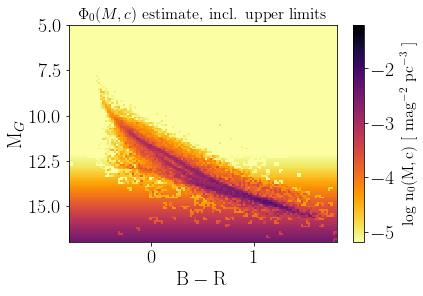

In [32]:

                            
plt.imshow(combined_upper_limits, extent=[BmRmin,BmRmax,MGmax,MGmin],aspect='auto',interpolation='none',cmap=reverse_inferno,vmin=-5.2,vmax=-1.2)

plt.xlabel(r'${\mathrm B}-{\mathrm R}$')
plt.ylabel(r'${\mathrm M}_G$')
plt.title(r'$\Phi_0(M,c)$ estimate, incl. upper limits',fontsize=16)
clb = plt.colorbar()
clb.set_label("log $\mathrm{n}_0(\mathrm{M,c})\ [~\mathrm{mag}^{-2}~ \mathrm{pc}^{-3}~]$", labelpad=4, rotation=90, fontsize=16)
#plt.text(-0.7,6.5, "combined estimate of $\Phi_0(M,c)$",fontdict=font)
#plt.text(0.5,8., "$\omega_{lim}=3$ mas",fontdict=font)
#plt.text(0.5,9.5, "$\omega/\delta\omega>$ "+str(plxSNmin),fontdict=font)
#filename = "/Users/rix/Science/Projects/Gaia/Gaia-Unlimited/WD300pc_plxSN_{}.png".format(str(np.int(plxSNmin)))
#plt.savefig(filename)
plt.show() 

In [33]:
from fastkde import fastKDE

var1 = BmR_c
var2 = MG_c
print(var1.shape,var2.shape)
x = np.linspace(-0.8, 1.5,257)
y = np.linspace(5.5,16.,257)
X,Y = np.meshgrid(x,y)
axes=(x,y)

#Do the self-consistent density estimate
myPDF,axes = fastKDE.pdf(var1,var2,axes=axes)

(113383,) (113383,)


Let's make a KDE density map of what's left in the clean sample

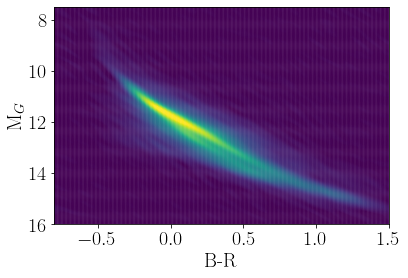

<Figure size 432x288 with 0 Axes>

In [34]:
z=(myPDF**0.69)
v1 = np.percentile(z,10.)
v2= np.percentile(z,99.9)

fig, ax = plt.subplots()
ax.scatter(X,Y, c=z, s=0.5, vmin=v1, vmax=v2)
#ax.scatter(X,Y, c=-z, s=0.5, cmap='inferno', edgecolor='')

# set limits and labels
ax.set_ylim(16.,7.5)
ax.set_xlim(-0.8, 1.5)
ax.set_xlabel('B-R')
ax.set_ylabel('M$_G$')


plt.show()
plt.savefig("out.png")